In [1]:
# push!(LOAD_PATH, joinpath(splitdir(pwd())[1], "src"))

In [2]:
# workspace()
# reload("SuperPix")
# using Images
# using SuperPix
# include("/Users/adare/repos/superpix/src/SuperPix.jl")

using Images
using Color
using LightGraphs
using Reactive, Interact

include("grids.jl")
include("means.jl")
include("prep.jl")
include("rag.jl")
include("recombine.jl")
include("slic.jl")
include("vis.jl")

    convert(Type{

Images.Image{Cdest<:Union(Color.AbstractAlphaColorValue{C<:Color.ColorValue{T},T<:Real},Color.ColorValue{T}),N,A<:AbstractArray{T,N}}}, Images.AbstractImageDirect{Csrc<:Union(Color.AbstractAlphaColorValue{C<:Color.ColorValue{T},T<:Real},Color.ColorValue{T}),N}) at /Users/adare/.julia/v0.4/Images/src/core.jl:229
is ambiguous with: 
    convert(Type{Images.Image{T,N,A<:AbstractArray{T,N}}}, Images.Image{T,N,A<:AbstractArray{T,N}}) at /Users/adare/.julia/v0.4/Images/src/core.jl:202.
To fix, define 
    convert(Type{Images.Image{_<:Union(Color.AbstractAlphaColorValue{C<:Color.ColorValue{T},T<:Real},Color.ColorValue{T}),N,A<:AbstractArray{T,N}}}, Images.Image{_<:Union(Color.AbstractAlphaColorValue{C<:Color.ColorValue{T},T<:Real},Color.ColorValue{T}),N,A<:AbstractArray{T,N}})
before the new definition.


segment_overlay (generic function with 1 method)

In [3]:
row_range = 91:380;
col_range = 151:750;

Lab Images.Image with:
  data: 600x290 Array{Color.Lab{Float32},2}
  properties:
    timedim: 0
    spatialorder:  x y
    pixelspacing:  1.0 1.0

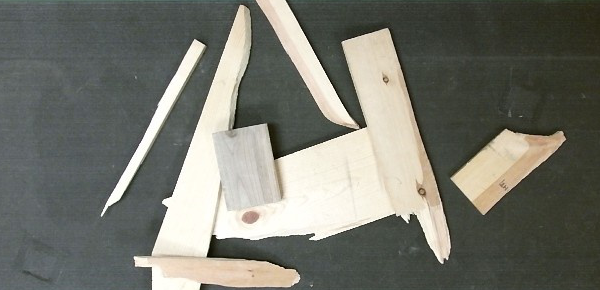

In [4]:
# Read in color image and convert to CIE Lab color space

imrgb = imread("../imgs/color_1.jpg")

# Convert to CIELAB color space for improved gradients and color distances.
imlab = convert(Image{Color.Lab}, map(Float32, separate(imrgb["x", col_range, "y", row_range])))
imlab.properties["spatialorder"] = ["x","y"]

show(imlab)
imlab

Before rescaling: min, max = 0.0 0.2168307
After rescaling:  min, max = 0.0 1.0


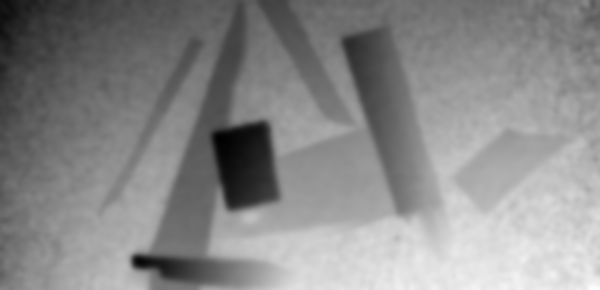

In [5]:
# Read in depth image and preprocess to improve contrast

imdep = imread("../imgs/depth_1.png")
dep = convert(Array, map(Float32, separate(imdep["x", col_range, "y", row_range])))

# Remove the singleton dimension
dep = reshape(dep, length(col_range), length(row_range))

println("Before rescaling: min, max = ", minimum(dep), " ", maximum(dep))
# grayim(dep)

for i=1:2
    mindep = minimum(dep[dep .> 0])
    dep = clamp(dep, mindep, maximum(dep)) - mindep
    dep /= maximum(dep)
end

# Gaussian blur helps to smooth over empty pixels and noise
dep = imfilter_gaussian(dep, [3,3])

mindep = minimum(dep[dep .> 0])
dep = clamp(dep, mindep, maximum(dep)) - mindep
dep /= maximum(dep)

println("After rescaling:  min, max = ", minimum(dep), " ", maximum(dep))
grayim(dep)

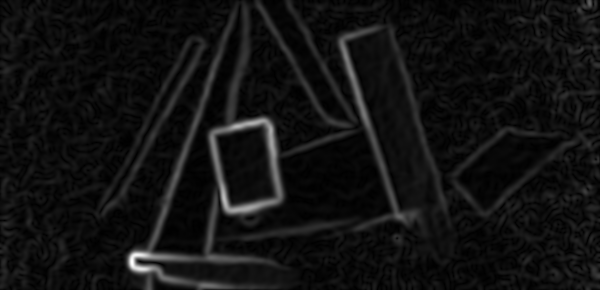

In [6]:
# Compute depth image gradients

gx, gy = imgradients(dep, "ando5")
depgrad = magnitude(data(gx),data(gy))

# Scale gradient magnitudes to range from 0 to 1
mingrad = minimum(depgrad[depgrad .> 0])
depgrad = clamp(depgrad, mingrad, maximum(depgrad)) - mingrad
depgrad /= maximum(depgrad)

grayim(depgrad)

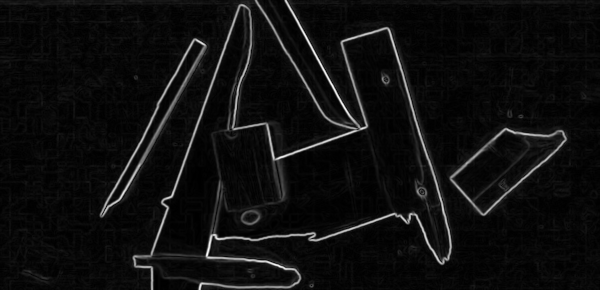

In [7]:
# Compute color image gradient (mean over L,a,b magnitudes)

gx, gy = imgradients(imlab, "ando5")
gradmag = magnitude(data(gx),data(gy))
gradmean = reshape(mean(gradmag, colordim(gx)), tuple(size_spatial(gx)...))

# Scale gradient magnitudes to range from 0 to 1
mingrad = minimum(gradmean[gradmean .> 0])
gradmean = clamp(gradmean, mingrad, maximum(gradmean)) - mingrad
gradmean /= maximum(gradmean)

grayim(gradmean)

In [8]:
nr, nc = size(imlab)

# Approximate number of requested superpixels.
k = 1000

# Cluster compactness parameter. 
# Large m favors roundness and uniformity (hex cells as m -> ∞)
# Small m favors color edge adherence.
# Note: k and m are coupled, since the clustering distance is a quadrature
# sum of spatial_distance/s and color_distance/m where s = sqrt(h*w/k).
m = 10# Seed the clusters

grid = hexgrid(nr, nc, k);

# Shift grid points slightly away from edges
centers = adjusted_grid(grid, gradmean);

Dist calcs 1...elapsed time: 0.157620478 seconds
Cluster repositioning 1...elapsed time: 0.001766259 seconds
Dist calcs 2...elapsed time: 0.141789514 seconds
Cluster repositioning 2...elapsed time: 0.001384375 seconds
Dist calcs 3...elapsed time: 0.138777601 seconds
Cluster repositioning 3...elapsed time: 0.001500271 seconds
Dist calcs 4...elapsed time: 0.131416604 seconds
Cluster repositioning 4...elapsed time: 0.00120016 seconds
Dist calcs 5...elapsed time: 0.132632526 seconds
Cluster repositioning 5...elapsed time: 0.001246022 seconds
elapsed time: 0.9097328 seconds (954 MB allocated, 11.87% gc time in 44 pauses with 0 full sweep)


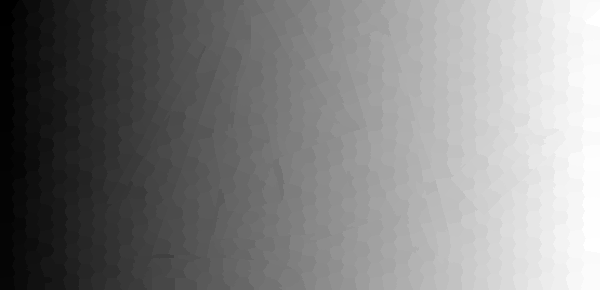

In [9]:
@time labels, nlabels = slic(imlab, centers, k, m, niter=5)
grayim(sc(labels))

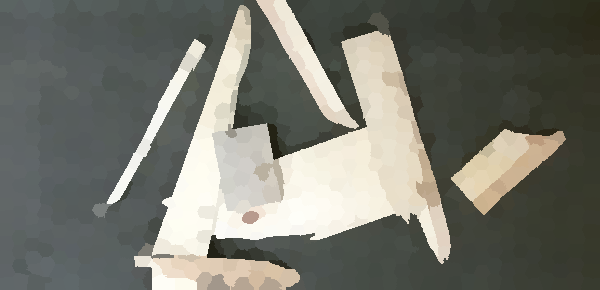

In [10]:
lab_means, color_superpix = color_means(imlab, labels, nlabels)
dep_means, depth_superpix = color_means(dep, labels, nlabels)
convert(Image{Color.RGB}, color_superpix)

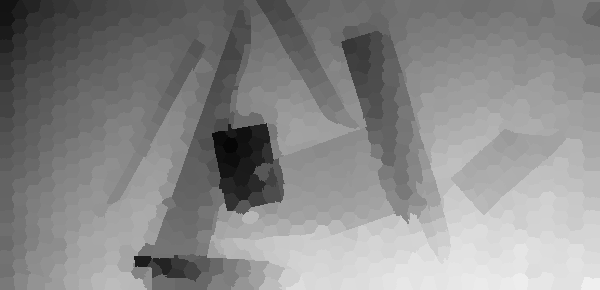

In [11]:
grayim(depth_superpix)

In [12]:
# Compute a regional adjacency graph from superpixels and find node positions

graph, edgewts, borders = adjacency_graph(labels, nlabels, lab_means, dep_means);
centroids = cluster_centroids(labels, nlabels);

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.07,"t",0.07,0.0:0.01:0.15)

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.5,"w",0.5,0.0:0.05:1.0)

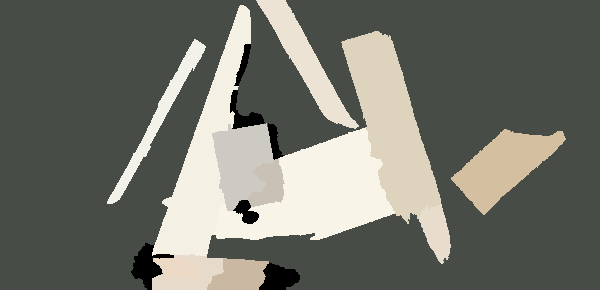

In [13]:
# Recombine superpixels into segments
# - t is the RAG edge weight threshold
# - w is the node-to-node depth distance weighting in 0-1 (color weighting is 1-w)
# - gw is the weighting of depth gradients relative to color+depth distance information

# @manipulate for t = 0.0:0.01:1.0, w = 0.0:0.05:1.0, gw = 0.0:0.01:1.0
@manipulate for t = 0.0:0.01:0.15, w = 0.0:0.05:1.0
    graph, edgewts, borders = adjacency_graph(labels, nlabels, lab_means, dep_means, depth_weight=w)

    # Experimental: include integrated gradient magnitude in graph edge weight
    #     gradwts = grad_weights(graph, centroids, depgrad)
    #     g = cut_graph(graph, (1-gw)*edgewts + gw*gradwts, t)

    g = cut_graph(graph, edgewts, t)
    seg_labels, nsegments = merged_superpixels(labels, g)

    seg_lab_means, color_segments = color_means(imlab, seg_labels, nsegments)
    seg_borders = segment_borders(seg_labels, color_segments)
    
    convert(Image{Color.RGB}, color_segments)
end

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.07,"t",0.07,0.0:0.01:0.15)

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.5,"w",0.5,0.0:0.1:1.0)

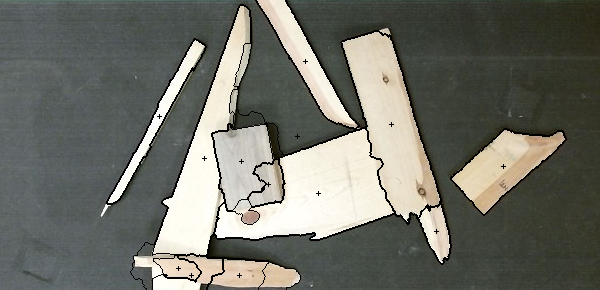

In [14]:
# @manipulate for t = 0.0:0.01:0.1
#     g = cut_graph(graph, edgewts, t)
#     seg_labels, nsegments = merged_superpixels(labels, g)

#     seg_lab_means, color_segments = color_means(imlab, seg_labels, nsegments)
#     seg_borders = segment_borders(seg_labels, color_segments);
#     convert(Image{Color.RGB}, seg_borders)
# end

@manipulate for t = 0.0:0.01:0.15, w = 0.0:0.1:1.0
    graph, edgewts, borders = adjacency_graph(labels, nlabels, lab_means, dep_means, depth_weight=w)
    g = cut_graph(graph, edgewts, t)
    seg_labels, nsegments = merged_superpixels(labels, g)

    seg_lab_means, color_segments = color_means(imlab, seg_labels, nsegments)
#     seg_borders = segment_borders(seg_labels, color_segments);
    seg_img = segment_overlay(seg_labels, imlab, color_segments, cluster_centroids(seg_labels, nsegments))
    convert(Image{Color.RGB}, seg_img)
end

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.07,"t",0.07,0.0:0.01:0.15)

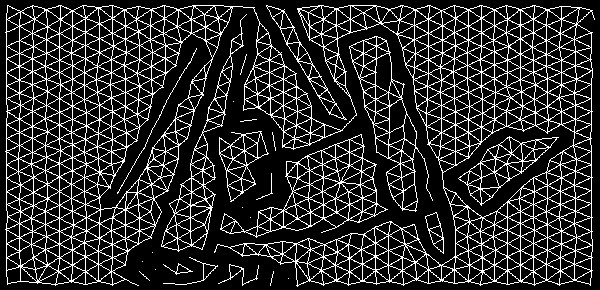

In [15]:
@manipulate for t = 0.0:0.01:0.15
    g = cut_graph(graph, edgewts, t)
    seg_labels, nsegments = merged_superpixels(labels, g)

    seg_lab_means, color_segments = color_means(imlab, seg_labels, nsegments)
    seg_borders = segment_borders(seg_labels, color_segments);
#     convert(Image{Color.RGB}, seg_borders)

    graph_edges = graph_image(g, centroids, nr, nc)
#     centroid_img = zeros(labels);
    for c in 1:nlabels
        row, col = centroids[c, 1], centroids[c, 2]
        if (1 <= row <= nr) && (1 <= col <= nc)
            graph_edges[row, col] = 1
        end
    end

#     graph_edges = graph_image(g, centroids, nr, nc)
    grayim(graph_edges)
    
#     OverlayImage((borders', graph_edges', centroid_img'),
#                     (Color.RGB(0.2,0.2,0.2), Color.RGB(0,0.5,1), Color.RGB(1,1,0)),
#                     ((0,1), (0,1), (0,1))
#                     )
end